# Predicting Band Gaps of 2D Materials with Machine Learning

## Exploratory Data Analysis

In [2]:
# Use matminer to load experimental band gaps dataset
from matminer.datasets import load_dataset

df = load_dataset("expt_gap")
df.head() # This prints the first 5 columns of the dataset

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


In [3]:
df.shape # This prints how many rows and columns the datset has

(6354, 2)

In [4]:
# Then, we use descriptive statistics to characterize the data set
df.describe()

,gap expt
count,6354.000000
mean,1.252225
std,1.539961
min,0.000000
25%,0.000000
50%,0.710000
75%,2.130000
max,11.700000


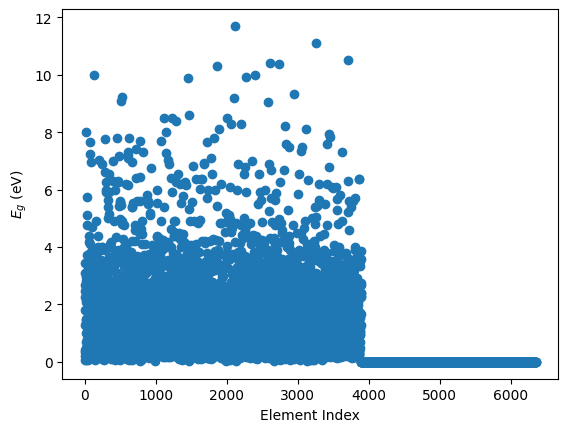

In [5]:
# Next, we want to plot what all of the band gaps look like
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, df.shape[0], df.shape[0]) # Element index which matches length of dataset

# Create and label scatter plot of band gaps (E_g)
plt.scatter(x, df['gap expt'])
plt.ylabel('$E_{g}$ (eV)')
plt.xlabel('Element Index')
plt.show()

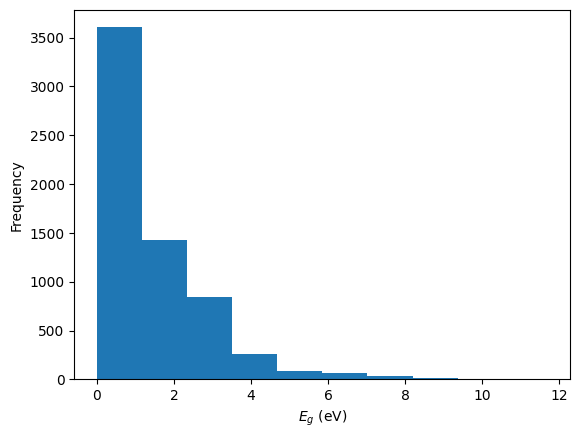

In [6]:
# Then, we can create a histogram of the bandgaps to look at underlying distribution
plt.hist(df['gap expt'])
plt.xlabel('$E_{g}$ (eV)')
plt.ylabel('Frequency')
plt.show()

# Just as we expect, most semiconductors have a band gap less than 4 eV

## Featurization

In [7]:
# Now we will add features into the dataset, which the models will later use.
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(df, "formula") # Simply turns the molecular names into their elements
df.head() # Show what the beginning of the dataset looks like

StrToComposition:   0%|          | 0/6354 [00:00<?, ?it/s]

,formula,gap expt,composition
0,Hg0.7Cd0.3Te,0.35,"(Hg, Cd, Te)"
1,CuBr,3.08,"(Cu, Br)"
2,LuP,1.30,"(Lu, P)"
3,Cu3SbSe4,0.40,"(Cu, Sb, Se)"
4,ZnO,3.44,"(Zn, O)"


In [8]:
# Then we will use The Materials Agnostic Platform for Informatics and Exploration (Magpie) to compute attributes.
# Cite the following link: https://www.nature.com/articles/npjcompumats201628
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name='magpie')
df = ep_feat.featurize_dataframe(df, col_id='composition', ignore_errors=True) # featurizer computes descriptors based on the composition column generated before
df.head()

C:\Users\benia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/6354 [00:00<?, ?it/s]

,formula,gap expt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Hg0.7Cd0.3Te,0.35,"(Hg, Cd, Te)",48.0,80.0,32.0,61.20,13.1600,52.0,70.0,...,0.000000,0.000000,0.000000,0.0,152.0,194.0,42.0,163.200,11.200,152.0
1,CuBr,3.08,"(Cu, Br)",29.0,35.0,6.0,32.00,3.0000,29.0,64.0,...,0.000000,0.000000,0.000000,0.0,64.0,225.0,161.0,144.500,80.500,64.0
2,LuP,1.30,"(Lu, P)",15.0,71.0,56.0,43.00,28.0000,15.0,41.0,...,0.002247,0.001124,0.001124,0.0,2.0,194.0,192.0,98.000,96.000,2.0
3,Cu3SbSe4,0.40,"(Cu, Sb, Se)",29.0,51.0,22.0,34.25,4.1875,34.0,64.0,...,0.000000,0.000000,0.000000,0.0,14.0,225.0,211.0,112.125,98.125,14.0
4,ZnO,3.44,"(Zn, O)",8.0,30.0,22.0,19.00,11.0000,8.0,69.0,...,0.000000,0.000000,0.000000,0.0,12.0,194.0,182.0,103.000,91.000,12.0


In [9]:
# The next thing we can do is guess the oxidation states
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers.composition import OxidationStates

df = CompositionToOxidComposition().featurize_dataframe(df, 'composition', ignore_errors=True)

# We then use this guess to apply the electronegativitydiff featurizer
df = OxidationStates().featurize_dataframe(df, 'composition_oxid', ignore_errors=True)
df.head()

CompositionToOxidComposition:   0%|          | 0/6354 [00:00<?, ?it/s]

OxidationStates:   0%|          | 0/6354 [00:00<?, ?it/s]

,formula,gap expt,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,composition_oxid,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
0,Hg0.7Cd0.3Te,0.35,"(Hg, Cd, Te)",48.0,80.0,32.0,61.20,13.1600,52.0,70.0,...,194.0,42.0,163.200,11.200,152.0,NaN,NaN,NaN,NaN,NaN
1,CuBr,3.08,"(Cu, Br)",29.0,35.0,6.0,32.00,3.0000,29.0,64.0,...,225.0,161.0,144.500,80.500,64.0,"(Cu+, Br-)",-1.0,1.0,2.0,1.414214
2,LuP,1.30,"(Lu, P)",15.0,71.0,56.0,43.00,28.0000,15.0,41.0,...,194.0,192.0,98.000,96.000,2.0,"(Lu3+, P3-)",-3.0,3.0,6.0,4.242641
3,Cu3SbSe4,0.40,"(Cu, Sb, Se)",29.0,51.0,22.0,34.25,4.1875,34.0,64.0,...,225.0,211.0,112.125,98.125,14.0,"(Cu+, Sb5+, Se2-)",-2.0,5.0,7.0,3.043544
4,ZnO,3.44,"(Zn, O)",8.0,30.0,22.0,19.00,11.0000,8.0,69.0,...,194.0,182.0,103.000,91.000,12.0,"(Zn2+, O2-)",-2.0,2.0,4.0,2.828427


In [14]:
# To save execution time, we will cache the featurized data into a csv
# First, we clean up the data
excluded = ['composition', 'composition_oxid', 'formula'] # Don't consider these features
df = df.drop(excluded, axis=1) # Drop specified labels from columns

# Next, we shuffle and split the dataset into train (80%) and test (20%)
train = df.sample(frac=0.8) # Random sample of 80% of original dataset
test = df.drop(train.index).sample(frac=1) # Random sample of remaining dataset

# Then, we print the train and test datasets into csv
train.to_csv('bandgap_train.csv')
test.to_csv('bandgap_test.csv')

In [15]:
train.head()

,gap expt,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,...,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
2249,5.00,8.0,62.0,54.0,29.60,25.920,8.0,23.0,87.0,64.0,...,12.0,166.0,154.0,73.600,73.920,12.0,-2.0,3.0,5.0,3.535534
3143,3.10,3.0,48.0,45.0,18.75,10.625,16.0,1.0,88.0,87.0,...,70.0,229.0,159.0,144.625,74.625,70.0,-2.0,4.0,6.0,2.690371
265,1.72,33.0,52.0,19.0,44.40,9.120,52.0,84.0,90.0,6.0,...,152.0,166.0,14.0,157.600,6.720,152.0,-3.0,4.0,7.0,4.107919
2533,0.55,15.0,48.0,33.0,34.80,15.840,48.0,70.0,83.0,13.0,...,2.0,194.0,192.0,117.200,92.160,194.0,-3.0,2.0,5.0,3.535534
507,1.36,11.0,51.0,40.0,32.50,10.750,34.0,2.0,89.0,87.0,...,14.0,229.0,215.0,105.750,91.750,14.0,-2.0,3.0,5.0,2.683282


## Preparing Data for Model

In [44]:
# Then we will create a dataloader to efficient load data in batches
# This will reduce memory consumption and make training faster
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class BandgapDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = torch.tensor(row.drop('gap expt').values, dtype=torch.float32)
        y = torch.tensor(row['gap expt'], dtype=torch.float32)
        return x, y

In [45]:
# Determine optimum batch size through empirical testing, differences summarized below:
# Small size leads to noisy gradient estimates - find global minima but slow convergence
# Large size leads to smooth gradients - faster convergence but overfitting / poor generalization
train_batch_size = 16

# Load training and test data sets using defined class and PyTorch DataLoader to chunk data into batch sizes
train_set = BandgapDataset('bandgap_train.csv')
test_set = BandgapDataset('bandgap_test.csv')
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

# Test if DataLoader has been implemented correctly
train_dataloader_iter = iter(train_loader) # creates an iterator for the DataLoader
train_features= next(train_dataloader_iter)
print(f"Feature batch shape: {train_features[0].size()}") # 
print(f"Labels batch shape: {train_features[1].size()}") # 

Feature batch shape: torch.Size([16, 137])
Labels batch shape: torch.Size([16])


## Model Training

Simplest training scheme

In [67]:
# First, we begin by reading the cleaned training dataset created above
import pandas as pd
train = pd.read_csv('bandgap_train.csv')
train.head()

,Unnamed: 0,gap expt,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,minimum oxidation state,maximum oxidation state,range oxidation state,std_dev oxidation state
0,2249,5.00,8.0,62.0,54.0,29.60,25.920,8.0,23.0,87.0,...,12.0,166.0,154.0,73.600,73.920,12.0,-2.0,3.0,5.0,3.535534
1,3143,3.10,3.0,48.0,45.0,18.75,10.625,16.0,1.0,88.0,...,70.0,229.0,159.0,144.625,74.625,70.0,-2.0,4.0,6.0,2.690371
2,265,1.72,33.0,52.0,19.0,44.40,9.120,52.0,84.0,90.0,...,152.0,166.0,14.0,157.600,6.720,152.0,-3.0,4.0,7.0,4.107919
3,2533,0.55,15.0,48.0,33.0,34.80,15.840,48.0,70.0,83.0,...,2.0,194.0,192.0,117.200,92.160,194.0,-3.0,2.0,5.0,3.535534
4,507,1.36,11.0,51.0,40.0,32.50,10.750,34.0,2.0,89.0,...,14.0,229.0,215.0,105.750,91.750,14.0,-2.0,3.0,5.0,2.683282


In [68]:
# Calculate the missing value using the same feature with univariate imputer
from sklearn.impute import SimpleImputer
import numpy as np

# We specifically use the unsupervised (no target values supplied) mean value strategy below
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = train.drop('gap expt', axis=1) # we call all columns except for the first one - target value
X_imputed = imputer.fit_transform(X)
if np.isnan(X_imputed).any():
    print("NaN values still exist in the imputed dataset.")
else:
    print("All NaN values have been imputed successfully.")

All NaN values have been imputed successfully.


In [69]:
# Then, we start by performing a very simple linear regression using scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

x = pd.DataFrame(X_imputed) # turn numpy array from imputed features into pandas DataFrame
y = train['gap expt'] # target value
model = LinearRegression()
model.fit(x, y)

# We can get fitting statistics as shown below
print(f'Training R^2 = {model.score(x, y):f}') # prediction determination coefficient
print(f'Training RMSE = {np.sqrt(mean_squared_error(y_true=y, y_pred=model.predict(x))):f}') # root mean squared error

Training R^2 = 0.620623
Training RMSE = 0.953791


In [70]:
# Next, we perform splitting the small training dataset into training and testing data (weird)
from sklearn.model_selection import KFold, cross_val_score

# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
r2_scores = cross_val_score(model, x, y, scoring='r2', cv=crossvalidation, n_jobs=1)

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.601
Folds: 10, mean RMSE: 0.976


In [71]:
# Let's look at the affect of having more testing data to look at on the model accuracy
from sklearn.metrics import r2_score

test = pd.read_csv('bandgap_test.csv')
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_test = test.drop('gap expt', axis=1) # we call all columns except for the first one - target value
X_test_imputed= imputer.fit_transform(X_test)
x_test = pd.DataFrame(X_test_imputed) # turn numpy array from imputed features into pandas DataFrame
y_test = test['gap expt'] # target value

y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Test RMSE: {rmse:2f}')
print(f'Test R2: {r2:2f}')

# As expected this causes the accuracy to decrease significantly, maybe model overfitting?

Test RMSE: 756.795062
Test R2: -253006.913679


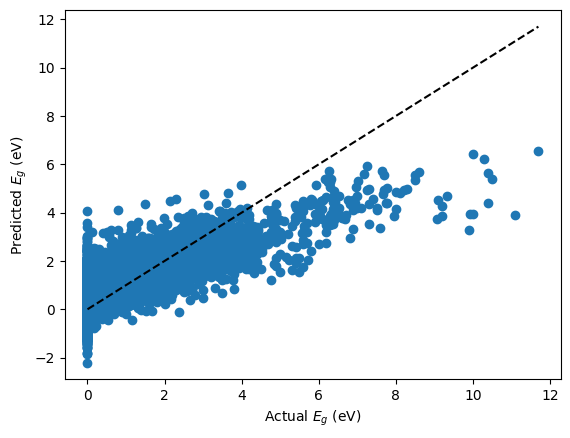

In [80]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

# Scatter plot of cross-validation predicted values as a function of actual values
plt.scatter(y, cross_val_predict(model, x, y, cv=crossvalidation))

# Mark what the perfect prediction should look like (1:1)
plt.plot([min(y), max(y)], [min(y), max(y)], color='k', linestyle='--')
plt.xlabel('Actual $E_{g}$ (eV)')
plt.ylabel('Predicted $E_{g}$ (eV)')
plt.show()

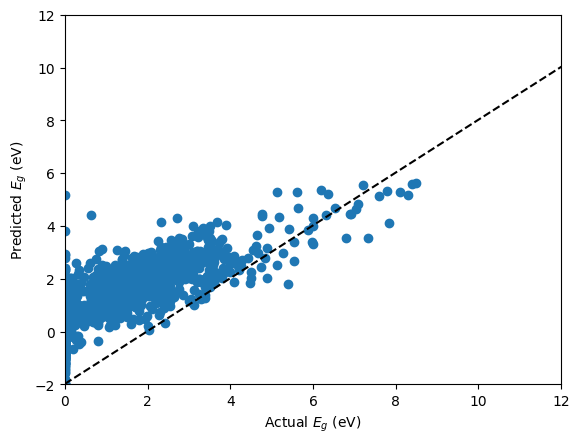

In [ ]:
# Scatter plot of actual vs predicted testing dataset Eg values
plt.scatter(y_test, y_pred)

# Mark what the perfect prediction should look like (1:1)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='k', linestyle='--')
plt.ylim([-2, 12])
plt.xlim([0, 12])
plt.xlabel('Actual $E_{g}$ (eV)')
plt.ylabel('Predicted $E_{g}$ (eV)')
plt.show()

In [76]:
# As a final effort for this toy model
# we will try to use genetic optimization algorithm to enhance the regression approach
from tpot import TPOTRegressor

# Define genetic algorithm parameters
SEED = 12
GENERATIONS = 5
POP_SIZE = 100
CV = 5

# Define the TOPT sklearn regression function
tpot = TPOTRegressor(
    generations=GENERATIONS,
    population_size=POP_SIZE,
    random_state=SEED,
    config_dict="TPOT light",
    n_jobs=1,
    cv=CV,
    verbosity=2,
)

tpot.fit(x, y) # Fit model

# Test model accuracy using test dataset
preds = tpot.predict(x_test)
print(r2_score(y_test, preds)) # evaluate model accuracy

# Note how much higher the model accuracy is now as R^2=0.9

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.2884798509056533

Generation 2 - Current best internal CV score: -0.2884798509056533

Generation 3 - Current best internal CV score: -0.2884798509056533

Generation 4 - Current best internal CV score: -0.28765735531152803

Generation 5 - Current best internal CV score: -0.28765735531152803

Best pipeline: RidgeCV(DecisionTreeRegressor(input_matrix, max_depth=10, min_samples_leaf=16, min_samples_split=17))
0.9017782161014226


In [78]:
# Let's calculate this refined model's accuracy
r2_opt = r2_score(y_test, preds)
rmse_opt = np.sqrt(mean_squared_error(y_test, preds))
print(f'Testing R2: {r2_opt}')
print(f'Testing RMSE: {rmse_opt}')

Testing R2: 0.9017782161014226
Testing RMSE: 0.471536315410091


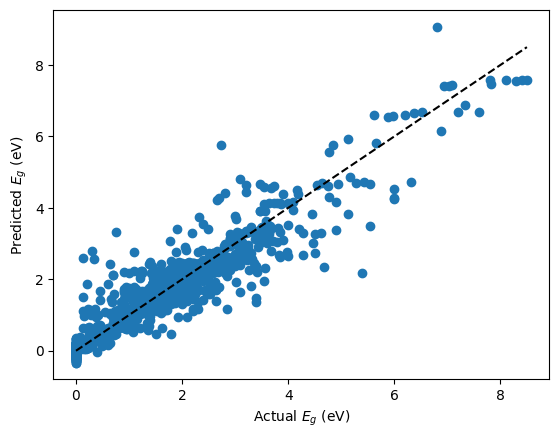

In [79]:
# Scatter plot of actual vs predicted testing dataset Eg values
plt.scatter(y_test, preds)

# Mark what the perfect prediction should look like (1:1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='k', linestyle='--')
plt.xlabel('Actual $E_{g}$ (eV)')
plt.ylabel('Predicted $E_{g}$ (eV)')
plt.show()